In [1]:
#import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#from inference import fit_additive,fit_multiplicative
#import emachine as EM
from direct_info import direct_info,frequency

from data_processing import data_processing
import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

#data_path = '../protein/Pfam-A.full'

data_path = '../'

from scipy.sparse import csr_matrix
import timeit
from joblib import Parallel, delayed

In [2]:
import emachine as EM

In [3]:
np.random.seed(1)
pfam_id = 'PF00186'
#pfam_id = sys.argv[1]

ipdb = 0

ext_name = '%s/%02d'%(pfam_id,ipdb)

#--------------------------------------------
# read data
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))
npdb = pdb.shape[0]

pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

tpdb = int(pdb[ipdb,1])

In [4]:
# data processing
s0,cols_removed = data_processing(data_path,pfam_id,ipdb,\
                  gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)

In [5]:
# inferring h0 and w
l,n_var = s0.shape

#m = 21
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

mx_sum = mx.sum()
#my_sum = mx.sum() #!!!! my_sum = mx_sum
#n_linear = n_var*(m-1)
n_linear = mx_sum - n_var

In [6]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
#onehot_encoder = OneHotEncoder(sparse=False,categories=mx)
seqs_onehot = onehot_encoder.fit_transform(s0)

print('compute ops')
ops,cov = EM.operators(seqs_onehot,n_var,i1i2,mx)

ops = csr_matrix(ops)
print(ops.shape)

compute ops
1565 1436281 1437846
(6734, 1437846)


In [7]:
print('infer w:')
start_time = timeit.default_timer()

eps_list = np.linspace(0.1,1.,19)
n_eps = len(eps_list)
res = Parallel(n_jobs = n_eps)(delayed(EM.fit)\
        (ops,cov,n_var,mx,eps=eps,max_iter=100)\
        for eps in eps_list)

run_time = timeit.default_timer() - start_time
print('run time:',run_time) 

infer w:
run time: 453.4191291049938


In [11]:
w_eps = np.array([res[i][0] for i in range(len(res))])
e_eps = np.array([res[i][1] for i in range(len(res))])

#ieps = np.argmax(E_eps)
#w = w_eps[ieps]
#print('optimal eps:', eps_list[ieps])

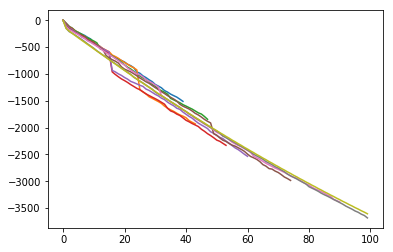

In [17]:
import matplotlib.pyplot as plt
for i in range(9):
    #print(e_eps[int(2*i)])
    plt.plot(e_eps[int(2*i)])
plt.show()